# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

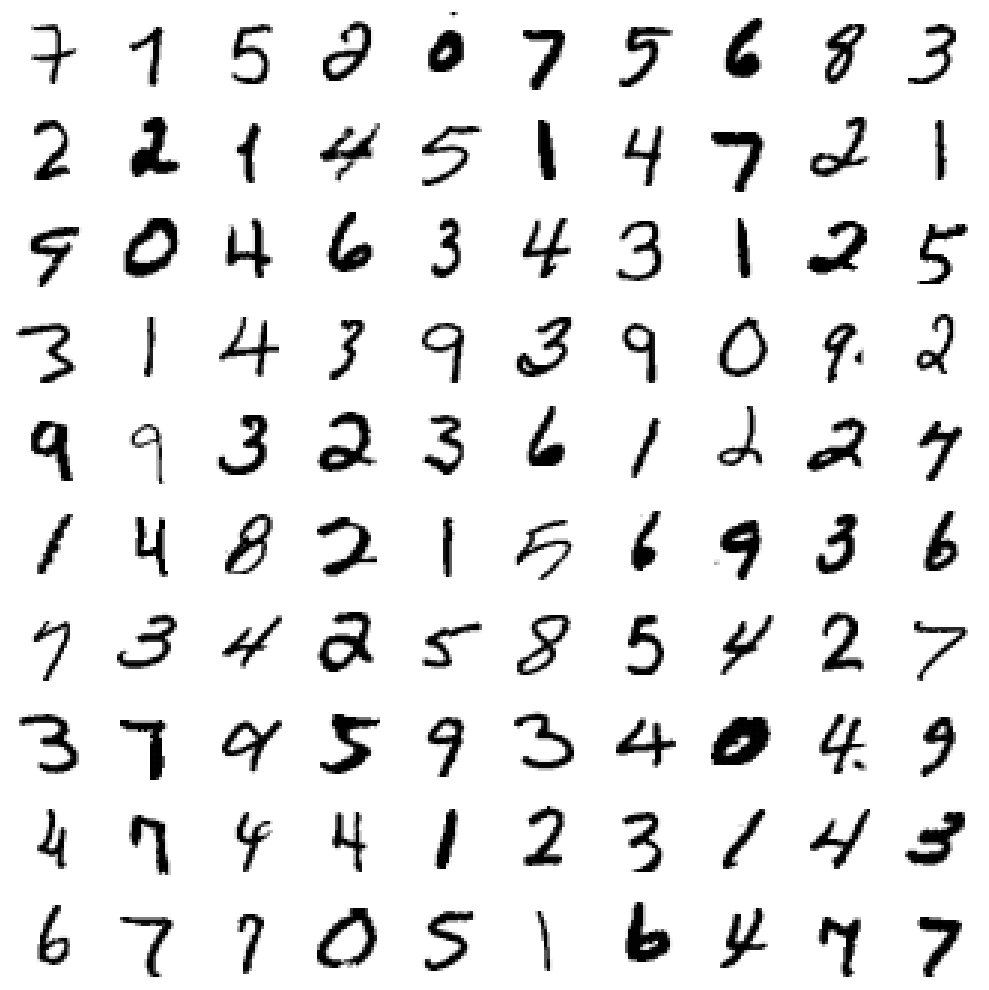

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

params_model1 = model.count_params()

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Compile and train the network (note that this could take a while).

In [3]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.8338 - loss: 0.5233 - val_accuracy: 0.9829 - val_loss: 0.0537
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9720 - loss: 0.0920 - val_accuracy: 0.9877 - val_loss: 0.0361
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9800 - loss: 0.0657 - val_accuracy: 0.9874 - val_loss: 0.0360
Epoch 4/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.9835 - loss: 0.0538 - val_accuracy: 0.9911 - val_loss: 0.0293
Epoch 5/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.9862 - loss: 0.0422 - val_accuracy: 0.9907 - val_loss: 0.0294
Epoch 6/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.9876 - loss: 0.0401 - val_accuracy: 0.9900 - val_loss: 0.0307
Epoch 7/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.9891 - loss: 0.0348 - val_accuracy: 0.9905 - val_loss: 0.0286
Epoch 8/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.9905 - loss: 0.0295 - 

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [4]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028796499595046043
Test accuracy: 0.9922999739646912


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


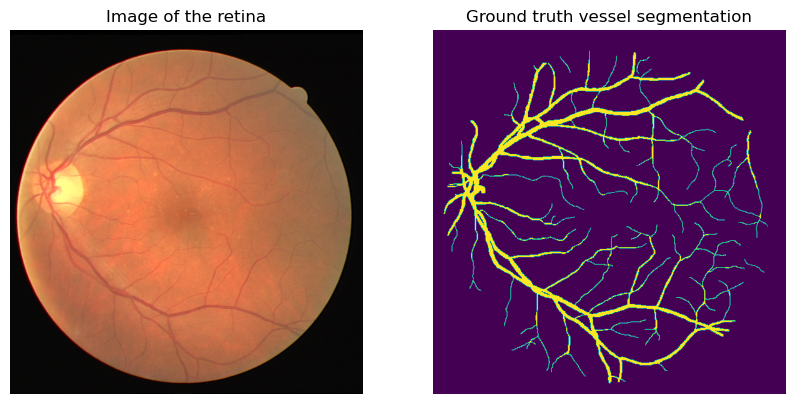

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = 'C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/M - Jaar 1/Machine Learning in Medical Imaging/8dm50-machine-learning/practicals/data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


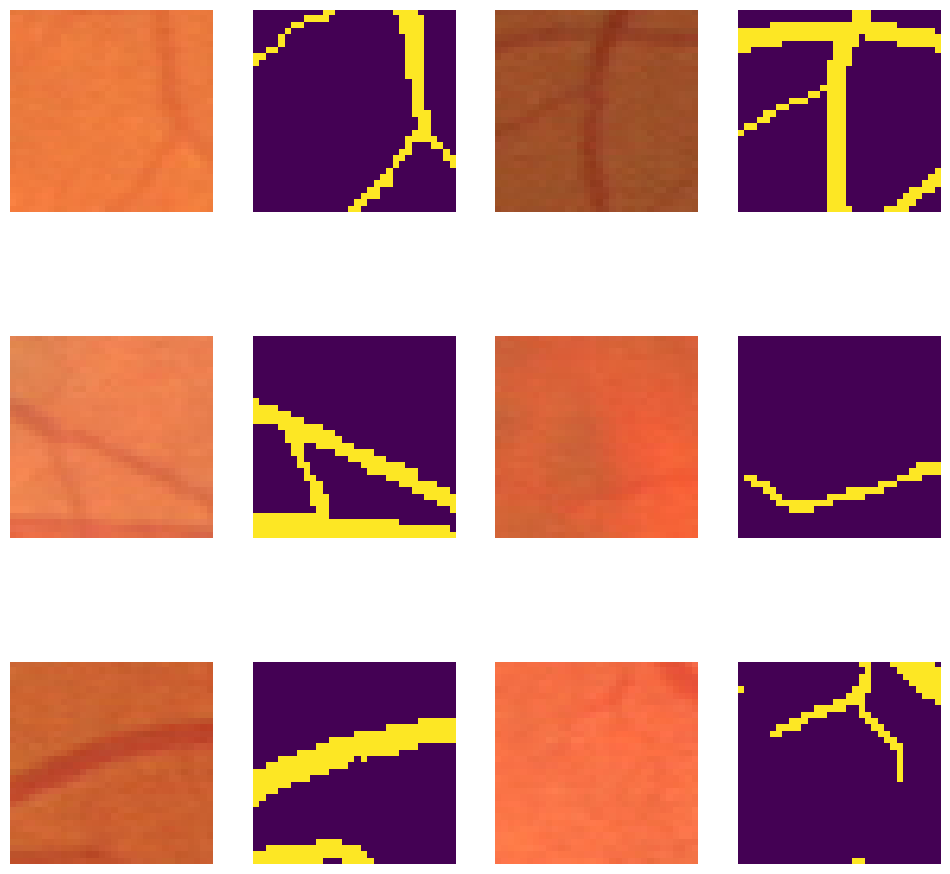

In [8]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [9]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [14]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 25
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/25
50/50 - 29s - 584ms/step - accuracy: 0.7871 - loss: 0.5500 - val_accuracy: 0.9211 - val_loss: 0.4644
Epoch 2/25
50/50 - 16s - 324ms/step - accuracy: 0.9459 - loss: 0.3309 - val_accuracy: 0.7184 - val_loss: 0.4999
Epoch 3/25
50/50 - 17s - 345ms/step - accuracy: 0.9565 - loss: 0.2381 - val_accuracy: 0.7077 - val_loss: 0.4346
Epoch 4/25
50/50 - 17s - 334ms/step - accuracy: 0.9580 - loss: 0.1879 - val_accuracy: 0.6949 - val_loss: 0.4886
Epoch 5/25
50/50 - 17s - 340ms/step - accuracy: 0.9583 - loss: 0.1572 - val_accuracy: 0.9212 - val_loss: 0.2567
Epoch 6/25
50/50 - 17s - 333ms/step - accuracy: 0.9575 - loss: 0.1495 - val_accuracy: 0.8702 - val_loss: 0.3096
Epoch 7/25
50/50 - 17s - 333ms/step - accuracy: 0.9581 - loss: 0.1394 - val_accuracy: 0.9213 - val_loss: 0.3111
Epoch 8/25
50/50 - 17s - 335ms/step - accuracy: 0.9626 - loss: 0.1203 - val_accuracy: 0.9224 - val_loss: 0.3106
Epoch 9/25
50/50 - 17s - 336ms/step - accuracy: 0.9624 - loss: 0.1167 

### Visualizing the segmentation results

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


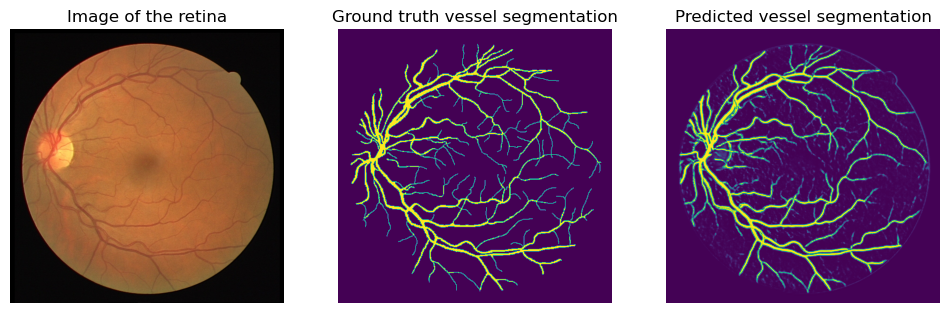

In [15]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

In [12]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model2.add(Conv2D(24, (6, 6), activation='relu'))
model2.add(Conv2D(21, (1, 1), activation='relu'))
model2.add(Conv2D(10, (1, 1), activation='softmax'))
model2.add(Reshape([10]))

params_model2 = model2.count_params()

model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 6, 6, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 1, 1, 24)            │         221,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 1, 1, 21)            │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 1, 1, 10)            │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,873 (4.58 MB)

 Trainable params: 1,199,873 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print('Nr of params model 1: ', params_model1)
print('Nr of params model 2: ', params_model2)

Nr of params model 1:  1199882
Nr of params model 2:  1199873


In [15]:
model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.9682 - loss: 0.1139 - val_accuracy: 0.9867 - val_loss: 0.0415
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - accuracy: 0.9872 - loss: 0.0424 - val_accuracy: 0.9876 - val_loss: 0.0414
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 185ms/step - accuracy: 0.9909 - loss: 0.0312 - val_accuracy: 0.9904 - val_loss: 0.0340
Epoch 4/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 184ms/step - accuracy: 0.9937 - loss: 0.0209 - val_accuracy: 0.9920 - val_loss: 0.0259
Epoch 5/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.9952 - loss: 0.0150 - val_accuracy: 0.9915 - val_loss: 0.0294
Epoch 6/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 176ms/step - accuracy: 0.9958 - loss: 0.0133 - val_accuracy: 0.9916 - val_loss: 0.0318
Epoch 7/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 90s 192ms/step - accuracy: 0.9961 - loss: 0.0131 - val_accuracy: 0.9916 - val_loss: 0.0332
Epoch 8/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - accuracy: 0.9963 - loss: 0

In [16]:
score2 = model2.evaluate(x_test, y_test, verbose=0)

print('Test loss model 1:', score[0])
print('Test loss model 2:', score2[0])
print('Test accuracy model 1:', score[1])
print('Test accuracy model 2:', score2[1])

Test loss model 1: 0.028796499595046043
Test loss model 2: 0.034404363483190536
Test accuracy model 1: 0.9922999739646912
Test accuracy model 2: 0.9912999868392944


A second model architecture has been set up without the use of dense layers but only with convolutional layers. This model uses only 9 parameters less than the original model. 
When tested on the same data, it can be observed that the test loss and accuracy of the fully-convolutional model very closely approach the values of the original model.

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

The encoder part of the UNet architecture is for capturing the context of the input image, while the decoder is for recovering the spatial resolution of the input image and reconstructing the segmentation map. The skip connections directly connect the layers of the encoder and decoder paths. The purpose of the skip connections is to bypass the bottleneck part of the model, which is the transition between the encoder and decoder. Another feature of the skip connecions is giving detailed information about the input image to the decoder part of the architeture. 

The encoder path reduces the spatial dimensions, so fine-grained details could be lost from the input image. When reconstructing in the decoder part, those details cannot be implemented again without using the skip connections. The skip connections provide fine-grained details to the decoder, making the reconstruction more detailed. In conclusion, without the skip connections, UNet can still make predictions, but some fine-grained details could be lost. Additionally, the skip connections are important for backpropagation during model training. With skip connections, the gradient flow is improved in the encoder part of the network.


## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.